## ДЗ №3: Рекуррентные нейронные сети.  Обработка естественного языка

### Пожалуйста, заполните имя

In [1]:
STUDENT_NAME = "Ryabov Fedor" # For example, Fedor Petriaikin

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
import pandas
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.autograd import Variable
from tqdm import tqdm
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
%matplotlib inline

**Не удаляйте клетки из этого jupyter-notebok! Это затруднит проверку!**

В этом задании вам предстоит попробовать различные рекуррентные архитектуры для предсказания временного ряда и написания простейшего чат-бота.


### Часть 1. Предсказание временного ряда

а) Напишите свою реализацию LSTM
<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [239]:
# Кстати, на вход в pytorch-реализацию можно подавать последовательности разной длины.
# См. torch.nn.utils.rnn.pack_padded_sequence() и torch.nn.utils.rnn.pack_sequence()
class LSTM_my(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_my, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.linear_f = nn.Linear(input_size + hidden_size, hidden_size)
        self.linear_i = nn.Linear(input_size + hidden_size, hidden_size)
        self.linear_g = nn.Linear(input_size + hidden_size, hidden_size)
        self.linear_o = nn.Linear(input_size + hidden_size, hidden_size)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.hid2out = nn.Linear(hidden_size, hidden_size)
        self.pred_layer = nn.Linear(hidden_size, 1)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_size),
                            torch.zeros(1, 1, self.hidden_size))
    
    # Пропускает через себя последовательность и выдает последний выход
    # X: (seq_len, batch_size, input_size)
    # hidden = (hidden, C): (batch_size, hidden_size)x2 - чтобы начать предсказания с какого-то момента
    # Если None, инициализировать нулями
    # Возвращает out, h, c, где (h, c) - выход и скрытое состояние после последнего элемента
    # out - (seq_len, batch, hidden_size) - выходы каждого слоя
    def lstm_cell(self, x):
        hidden, c = self.hidden_cell
        concat = torch.cat((hidden.squeeze(0), x.unsqueeze(0)), dim=1)
        f_t = self.sigmoid(self.linear_f(concat))
        i_t = self.sigmoid(self.linear_i(concat))
        g_t = self.tanh(self.linear_g(concat))
        o_t = self.sigmoid(self.linear_o(concat))
        c = torch.mul(f_t, c)
        i_g = torch.mul(i_t, g_t)
        c = torch.add(c, i_g)
        hidden = self.tanh(c)
        hidden = torch.mul(hidden, o_t)
        out = self.sigmoid(self.hid2out(hidden))
        return out, (hidden, c)
    def forward(self, X, look_forward=1):
        output = []
        for i, x in enumerate(X):
            out, self.hidden_cell = self.lstm_cell(x)
        out = out.squeeze(0)
        predictions = self.pred_layer(out)
        prediction = predictions[-1]
        prediction_list = [prediction]
        for i in range(look_forward - 1):
            out, self.hidden_cell = self.lstm_cell(prediction)
            predictions = self.pred_layer(out.squeeze(0))
            prediction_list.append(predictions[-1])
        return torch.stack(prediction_list, dim=1)

б) Напишите код обучения LSTM на представленных данных

### Сразу оговорюсь - выбрал не adagrad, а adam. Лучше работал, хотелось красивых картинок. Обучал на 300 эпохах, постепенно снижая learning rate. look_forward=1 лучше всего получилось.

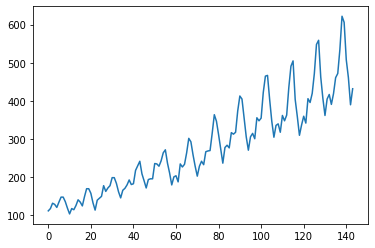

,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,112
1,118
2,132
3,129
4,121


In [253]:
# График (*)
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()
data = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
data.head()

In [254]:
# подготовливаем данные
dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [255]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

96 48


In [256]:
# Целевая переменная - сдвинутая последовательность значений входов
# look_back - на сколько смещен test относительно train (seq_len)
# look_forward - сколько нужно предсказать
def create_dataset(dataset, look_back=5, look_forward=1):
    dataX = []
    for i in range(len(dataset) - look_back):
        a = dataset[i: i + look_back]
        train_label = dataset[i + look_back: i + look_back + look_forward]
        dataX.append((a ,train_label))
    return dataX

In [257]:
# Пример подготовленных данных
look_back = 12
look_forward = 2
train_tensor = torch.FloatTensor(train).view(-1)
train_data = create_dataset(train_tensor, look_back=look_back, look_forward=look_forward)

In [258]:
learning_rate = 0.001
model = LSTM_my(1, 100, 1)

In [259]:
# Берет данные из dataloader, сам их сдвигает, формируя обучающую выборку
# В качестве функции ошибок возьмите MSELoss, оптимизатор - Adagrad
# В функцию можно добавить дополнительные параметры (например, max_epochs, условия останова...)
def TrainModel(model, train_data, all_losses, max_epochs=100, learning_rate = 0.001):
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for i in tqdm(range(max_epochs)):
        for seq, labels in train_data:
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_size),
                            torch.zeros(1, 1, model.hidden_size))
            if look_forward != 1:
                y_pred = model(seq.unsqueeze(1), look_forward = look_forward)
            else:
                y_pred = model(seq.unsqueeze(1))
            single_loss = loss_function(y_pred, labels)
            all_losses.append(single_loss.item())
            single_loss.backward()
            optimizer.step()

        if i % 25 == 1:
            print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
    return model, all_losses
all_losses = []
learning_rate = 0.001
for i in range(3):
    model, all_losses = TrainModel(model, train_data, all_losses, max_epochs=150, learning_rate = learning_rate)
    learning_rate /= 10

  0%|          | 0/150 [00:00<?, ?it/s]/home/fedor/miniconda3/envs/venv_for_homeworks/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/fedor/miniconda3/envs/venv_for_homeworks/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
  1%|▏         | 2/150 [00:01<01:16,  1.94it/s]

epoch:   1 loss: 0.00961844


 18%|█▊        | 27/150 [00:13<01:02,  1.97it/s]

epoch:  26 loss: 0.00786873


 35%|███▍      | 52/150 [00:26<00:50,  1.93it/s]

epoch:  51 loss: 0.00236445


 51%|█████▏    | 77/150 [00:39<00:37,  1.94it/s]

epoch:  76 loss: 0.00133539


 68%|██████▊   | 102/150 [00:51<00:24,  1.98it/s]

epoch: 101 loss: 0.00009085


 85%|████████▍ | 127/150 [01:03<00:11,  1.98it/s]

epoch: 126 loss: 0.00001104


  0%|          | 0/150 [00:00<?, ?it/s]

epoch: 149 loss: 0.0007253333


  1%|▏         | 2/150 [00:01<01:17,  1.92it/s]

epoch:   1 loss: 0.00290154


 18%|█▊        | 27/150 [00:13<01:02,  1.96it/s]

epoch:  26 loss: 0.00006939


 35%|███▍      | 52/150 [00:26<00:45,  2.15it/s]

epoch:  51 loss: 0.00004295


 51%|█████▏    | 77/150 [00:38<00:37,  1.93it/s]

epoch:  76 loss: 0.00003172


 68%|██████▊   | 102/150 [00:51<00:24,  1.94it/s]

epoch: 101 loss: 0.00002887


 85%|████████▍ | 127/150 [01:03<00:11,  1.95it/s]

epoch: 126 loss: 0.00002694


  0%|          | 0/150 [00:00<?, ?it/s]

epoch: 149 loss: 0.0000230920


  1%|▏         | 2/150 [00:00<01:11,  2.06it/s]

epoch:   1 loss: 0.00002146


 18%|█▊        | 27/150 [00:13<01:02,  1.97it/s]

epoch:  26 loss: 0.00002164


 35%|███▍      | 52/150 [00:26<00:50,  1.95it/s]

epoch:  51 loss: 0.00002241


 51%|█████▏    | 77/150 [00:39<00:38,  1.89it/s]

epoch:  76 loss: 0.00002293


 68%|██████▊   | 102/150 [00:51<00:24,  1.96it/s]

epoch: 101 loss: 0.00002315


 85%|████████▍ | 127/150 [01:04<00:11,  1.97it/s]

epoch: 126 loss: 0.00002314


100%|██████████| 150/150 [01:16<00:00,  1.97it/s]

epoch: 149 loss: 0.0000229721


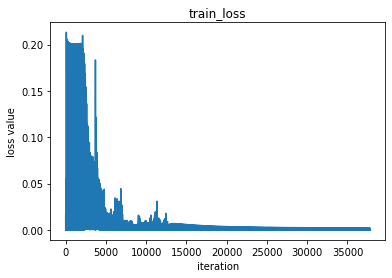

In [260]:
plt.plot(all_losses)
plt.title("train_loss")
plt.xlabel("iteration")
plt.ylabel("loss value")
plt.show()

In [261]:
look_back = train_tensor.size(0)
test_inputs = train_tensor[-look_back:].tolist()

In [262]:
def predict(model, test_inputs, look_back):
    model.eval()

    for i in range(test_size):
        seq = torch.FloatTensor(test_inputs[-look_back:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1, 1, model.hidden_size),
                            torch.zeros(1, 1, model.hidden_size))
            test_inputs.append(model(seq.unsqueeze(1)).item())
    return test_inputs
test_inputs = predict(model, test_inputs, look_back)

In [263]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[look_back:] ).reshape(-1, 1))

In [264]:
x = np.arange(144 - test_size, 144, 1)

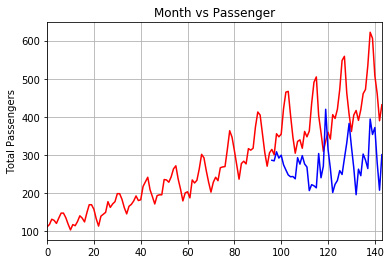

In [265]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(data, "r")
plt.plot(x, actual_predictions, "b")
plt.show()

в) Попробуйте обучить сеть с разными параметрами look_back, look_forward. Также попробуйте использовать различные hidden_size. Выведите предсказания на график (\*). Сделайте вывод.  
*Обратите внимание*: "Классический", однонаправленный LSTM имеет размерность выхода (seq_len, batch, hidden_size). Но иногда нужно "изменить" размерность выхода - для этого можно обучить Linear: hidden_size x need_size  

г) Сравните свой результат и результат с использованием nn.LSTM (на аналогичном числе эпох, hidden_size и т.п.)  

д) Попробуйте использовать nn.GRU. Сравните результаты

## TORCH LSTM

In [266]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size)

        self.linear = nn.Linear(hidden_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_size),
                            torch.zeros(1,1,self.hidden_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [270]:
# Пример подготовленных данных
look_back = 12
look_forward = 1
train_tensor = torch.FloatTensor(train).view(-1)
train_data = create_dataset(train_tensor, look_back=look_back, look_forward=look_forward)

In [271]:
model_TORCH = LSTM(1, 100, 1)

In [272]:
all_losses = []
learning_rate = 0.001
for i in range(3):
    model, all_losses = TrainModel(model_TORCH, train_data, all_losses, max_epochs=150, learning_rate = learning_rate)
    learning_rate /= 10

  1%|▏         | 2/150 [00:00<00:52,  2.79it/s]

epoch:   1 loss: 0.01314204


 19%|█▊        | 28/150 [00:08<00:24,  4.90it/s]

epoch:  26 loss: 0.00169253


 35%|███▍      | 52/150 [00:13<00:19,  4.98it/s]

epoch:  51 loss: 0.00654495


 51%|█████▏    | 77/150 [00:18<00:14,  4.99it/s]

epoch:  76 loss: 0.00149131


 69%|██████▊   | 103/150 [00:23<00:09,  5.03it/s]

epoch: 101 loss: 0.00043025


 85%|████████▌ | 128/150 [00:28<00:04,  5.00it/s]

epoch: 126 loss: 0.00069892


  0%|          | 0/150 [00:00<?, ?it/s]

epoch: 149 loss: 0.0007591509


  1%|▏         | 2/150 [00:00<00:33,  4.38it/s]

epoch:   1 loss: 0.00200065


 18%|█▊        | 27/150 [00:08<00:42,  2.88it/s]

epoch:  26 loss: 0.00007830


 35%|███▍      | 52/150 [00:19<00:58,  1.68it/s]

epoch:  51 loss: 0.00003491


 51%|█████▏    | 77/150 [00:29<00:28,  2.60it/s]

epoch:  76 loss: 0.00002022


 69%|██████▊   | 103/150 [00:38<00:14,  3.31it/s]

epoch: 101 loss: 0.00000989


 85%|████████▌ | 128/150 [00:45<00:05,  3.75it/s]

epoch: 126 loss: 0.00000181


  0%|          | 0/150 [00:00<?, ?it/s]

epoch: 149 loss: 0.0000004327


  1%|▏         | 2/150 [00:00<00:29,  4.96it/s]

epoch:   1 loss: 0.00000099


 18%|█▊        | 27/150 [00:07<00:26,  4.73it/s]

epoch:  26 loss: 0.00000481


 35%|███▍      | 52/150 [00:14<00:35,  2.76it/s]

epoch:  51 loss: 0.00000360


 51%|█████▏    | 77/150 [00:24<00:20,  3.55it/s]

epoch:  76 loss: 0.00000209


 68%|██████▊   | 102/150 [00:30<00:15,  3.06it/s]

epoch: 101 loss: 0.00000091


 85%|████████▍ | 127/150 [00:40<00:08,  2.77it/s]

epoch: 126 loss: 0.00000021


100%|██████████| 150/150 [00:48<00:00,  3.06it/s]

epoch: 149 loss: 0.0000000000


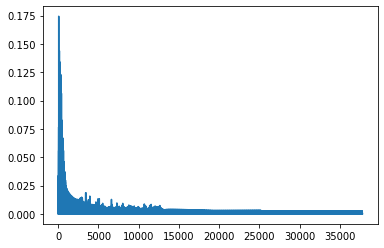

In [273]:
plt.plot(all_losses)
plt.title("train_loss")
plt.xlabel("iteration")
plt.ylabel("loss value")
plt.show()

In [274]:
look_back = train_tensor.size(0)
test_inputs = train_tensor[-look_back:].tolist()

In [275]:
test_inputs = predict(model, test_inputs, look_back)

In [276]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[look_back:] ).reshape(-1, 1))

In [277]:
x = np.arange(144 - test_size, 144, 1)

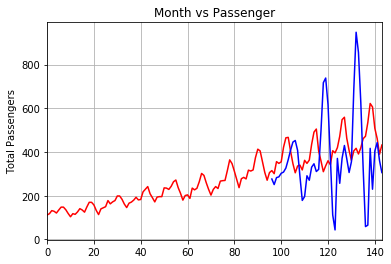

In [278]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(data, "r")
plt.plot(x, actual_predictions, "b")
plt.show()

## TORCH GRU

In [284]:
class GRU(nn.Module):
    def __init__(self, input_size=1, hidden_size=100, output_size=1):
        super().__init__()
        self.hidden_size = hidden_size

        self.lstm = nn.GRU(input_size, hidden_size)

        self.linear = nn.Linear(hidden_size, output_size)

        self.hidden_cell = torch.zeros(1,1,self.hidden_size)
                            
    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [285]:
# Пример подготовленных данных
look_back = 12
look_forward = 1
train_tensor = torch.FloatTensor(train).view(-1)
train_data = create_dataset(train_tensor, look_back=look_back, look_forward=look_forward)

In [286]:
GRU_TORCH = GRU(1, 100, 1)

In [289]:
def TrainModel_GRU(model, train_data, all_losses, max_epochs=100, learning_rate = 0.001):
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    for i in tqdm(range(max_epochs)):
        for seq, labels in train_data:
            optimizer.zero_grad()
            model.hidden_cell = torch.zeros(1, 1, model.hidden_size)
            if look_forward != 1:
                y_pred = model(seq.unsqueeze(1), look_forward = look_forward)
            else:
                y_pred = model(seq.unsqueeze(1))
            single_loss = loss_function(y_pred, labels)
            all_losses.append(single_loss.item())
            single_loss.backward()
            optimizer.step()

        if i % 25 == 1:
            print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

    print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
    return model, all_losses
all_losses = []
learning_rate = 0.001
for i in range(3):
    model, all_losses = TrainModel_GRU(GRU_TORCH, train_data, all_losses, max_epochs=150, learning_rate = learning_rate)
    learning_rate /= 10

  1%|▏         | 2/150 [00:00<00:56,  2.64it/s]

epoch:   1 loss: 0.00879483


 18%|█▊        | 27/150 [00:09<00:45,  2.73it/s]

epoch:  26 loss: 0.00174132


 35%|███▍      | 52/150 [00:19<00:36,  2.72it/s]

epoch:  51 loss: 0.00539426


 51%|█████▏    | 77/150 [00:28<00:27,  2.66it/s]

epoch:  76 loss: 0.00307386


 68%|██████▊   | 102/150 [00:37<00:18,  2.63it/s]

epoch: 101 loss: 0.00000027


 85%|████████▍ | 127/150 [00:47<00:08,  2.68it/s]

epoch: 126 loss: 0.00068151


  0%|          | 0/150 [00:00<?, ?it/s]

epoch: 149 loss: 0.0000152667


  1%|▏         | 2/150 [00:00<00:56,  2.62it/s]

epoch:   1 loss: 0.00100560


 18%|█▊        | 27/150 [00:10<00:47,  2.61it/s]

epoch:  26 loss: 0.00002859


 35%|███▍      | 52/150 [00:19<00:36,  2.69it/s]

epoch:  51 loss: 0.00001524


 51%|█████▏    | 77/150 [00:28<00:26,  2.73it/s]

epoch:  76 loss: 0.00001654


 68%|██████▊   | 102/150 [00:38<00:17,  2.69it/s]

epoch: 101 loss: 0.00003292


 85%|████████▍ | 127/150 [00:47<00:08,  2.64it/s]

epoch: 126 loss: 0.00004523


  0%|          | 0/150 [00:00<?, ?it/s]

epoch: 149 loss: 0.0000346063


  1%|▏         | 2/150 [00:00<00:58,  2.55it/s]

epoch:   1 loss: 0.00001432


 18%|█▊        | 27/150 [00:09<00:44,  2.75it/s]

epoch:  26 loss: 0.00000993


 35%|███▍      | 52/150 [00:18<00:36,  2.69it/s]

epoch:  51 loss: 0.00001185


 51%|█████▏    | 77/150 [00:28<00:28,  2.60it/s]

epoch:  76 loss: 0.00001256


 68%|██████▊   | 102/150 [00:37<00:18,  2.66it/s]

epoch: 101 loss: 0.00001273


 85%|████████▍ | 127/150 [00:43<00:04,  4.61it/s]

epoch: 126 loss: 0.00001258


100%|██████████| 150/150 [00:48<00:00,  3.07it/s]

epoch: 149 loss: 0.0000122714


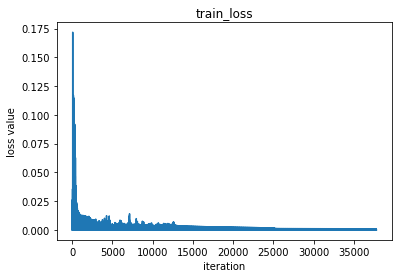

In [290]:
plt.plot(all_losses)
plt.title("train_loss")
plt.xlabel("iteration")
plt.ylabel("loss value")
plt.show()

In [291]:
look_back = train_tensor.size(0)
test_inputs = train_tensor[-look_back:].tolist()

In [292]:
test_inputs = predict(model, test_inputs, look_back)

In [293]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[look_back:] ).reshape(-1, 1))

In [294]:
x = np.arange(144 - test_size, 144, 1)

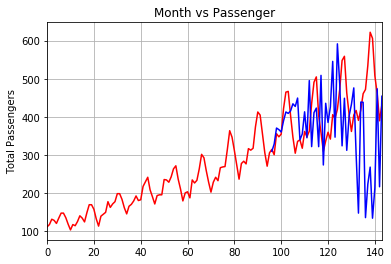

In [295]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(data, "r")
plt.plot(x, actual_predictions, "b")
plt.show()

### Часть 2. RNN и обработка текстов

В этом задании мы будем использовать файл author-quote.txt

In [3]:
np.random.seed(777)
torch.random.manual_seed(777)

In [4]:
lines = [x.split('\t')[1].strip() for x in open('author-quote.txt').readlines()]
lines[0]

'If you live to be a hundred, I want to live to be a hundred minus one day so I never have to live without you.'

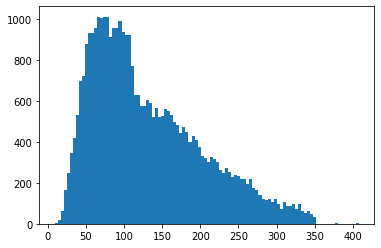

In [5]:
lines_len = []
for l in map(len, lines):
    lines_len.append(l)

plt.hist(lines_len, bins=100);

In [6]:
lines = [l for l in filter(lambda x: len(x) <= 50, lines)]
train_lines = lines[:int(0.7 * len(lines))]
test_lines = lines[int(0.7 * len(lines)):]
print(len(lines), len(train_lines), len(test_lines))

3621 2534 1087


In [7]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            all_characters = set.union(set(line), all_characters)
        all_characters = list(all_characters)+['<eos>', '<go>']
        self.char_to_id = {x[1]:x[0] for x in enumerate(all_characters)}
        self.id_to_char = {x[0]:x[1] for x in enumerate(all_characters)}
        self.size = len(all_characters)

    def encode(self, line):
        return np.array([self.char_to_id[x] for x in line])
    
    def decode(self, tokens):
        return ''.join([self.id_to_char[x] for x in tokens])
    
vocab = Vocabulary(lines)
print(vocab.char_to_id)

{'t': 0, 'B': 1, 'z': 2, 'P': 3, '0': 4, 'Z': 5, '$': 6, 'L': 7, 'p': 8, 'f': 9, '6': 10, 'q': 11, '!': 12, ',': 13, '3': 14, 'v': 15, 'c': 16, 'N': 17, 'Y': 18, 'I': 19, 'o': 20, 'k': 21, 'a': 22, 'X': 23, '2': 24, 'O': 25, 'n': 26, 'K': 27, 'Q': 28, ' ': 29, '9': 30, 'l': 31, '7': 32, '-': 33, 'D': 34, 'V': 35, '8': 36, 's': 37, "'": 38, 'R': 39, 'F': 40, 'G': 41, 'C': 42, '.': 43, 'r': 44, 'H': 45, 'x': 46, 'h': 47, 'S': 48, 'b': 49, 'T': 50, 'u': 51, 'U': 52, '4': 53, 'y': 54, ':': 55, 'g': 56, 'J': 57, 'm': 58, 'w': 59, ';': 60, '1': 61, '?': 62, 'j': 63, 'A': 64, 'W': 65, 'e': 66, 'd': 67, '5': 68, 'M': 69, '&': 70, 'i': 71, 'E': 72, '<eos>': 73, '<go>': 74}


In [49]:
# <go>, <eos> - специальные токены начала и конца последовательности, нужны для работы предсказаний
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        self.go = self.vocab.char_to_id['<go>']
        self.eos = self.vocab.char_to_id['<eos>']
        
    def __len__(self):
        return len(self.sentences)
        
    def __getitem__(self, idx):
        tokens = self.vocab.encode(self.sentences[idx])
        _input = np.hstack((np.array([self.go]), np.array(tokens)))
        _output = np.hstack((np.array(tokens), np.array([self.eos])))
        return _input, _output

In [50]:
# Для работы pack_padded_sequence
def compose_batch(batch):
#     print(batch[0][0])
    order = np.argsort([-len(x[0]) for x in batch])
    lengths = np.array([len(x[0]) for x in batch])
    go = torch.zeros(len(batch), lengths[order[0]]).long()
    eos = torch.zeros(len(batch), lengths[order[0]]).long()
    mask = torch.zeros(len(batch), lengths[order[0]]).long()
    for i in range(len(batch)):
        current_go, current_eos = batch[i]
        go[i, :len(current_go)] = torch.tensor(current_go)
        eos[i, :len(current_eos)] = torch.tensor(current_eos)
        mask[i, :len(current_go)] = 1
    mask = mask[order]
    go = go[order]
    eos = eos[order]
    lengths = lengths[order]
    return go, eos, mask, lengths

In [51]:
train = Quotes(train_lines, vocab)
test = Quotes(test_lines, vocab)
train_loader = DataLoader(train, shuffle=True, batch_size=64, collate_fn=compose_batch)
test_loader = DataLoader(test, shuffle=False, batch_size=64, collate_fn=compose_batch)

а) Напишите код класса Oracle

In [163]:
class Oracle(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super(Oracle, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.generator = nn.GRU(embedding_size, hidden_size, layers, batch_first=False)
        self.classifier = nn.Linear(hidden_size, vocabulary_size)
        self.softmax = nn.Softmax(dim=2)
    # 1) Генерируем эмбединги входных токенов (из _input), пакуем в pack_padded_sequence, используя lengths
    # 2) Запускаем generator на эмбедингах, пакуем его вывод в pad_packed_sequence
    # 3) Возвращаем предикты (пока без SoftMax) через self.classifier
    def forward(self, _input, lengths):
        embedding = self.embedding(_input)
        packed = pack_padded_sequence(embedding, lengths, batch_first=True)
        output, hidden = self.generator(packed)
        output, lengths = pad_packed_sequence(output, batch_first=True)
        logits = self.classifier(output)
        return logits

    # Генерирует последовательность (когда уже обучен). Токены переводим в id с помощью vocab.char_to_id,
    # обратно - с помощью vocab.id_to_char
    # Первый токен - <go>, делаем embeding. Далее generator -- classifier -- softmax.
    # Слово сэмплируем с помощью torch.distributions.Categorical, оно становится новым токеном
    # Повторяем, пока не будет <eos> или не достигнем max_len
    # Возвращаем - сгенерированную строку


    def generate(self, vocab, max_len=100, char="<go>", temperature=1):
        with torch.no_grad():
            
            hidden = torch.zeros(self.layers, 1, self.hidden_size)

            generated_text = ""

            for _ in range(max_len):

                input_token = vocab.char_to_id[char]
                input_token = torch.tensor([[input_token]])
                
                embedding = self.embedding(input_token)
                output, hidden = self.generator(embedding, hidden)
                logits = self.classifier(output)

                prediction = self.softmax(logits/temperature)
                char_idx = torch.distributions.Categorical(prediction).sample().item()
                char = vocab.id_to_char[char_idx]

                if char == "<eos>":
                    break

                generated_text += char
            return generated_text
            
        

б) Обучите модель. Приведите примеры сгенеррованных предложений

In [173]:
oracle = Oracle(vocab.size, embedding_size=32, hidden_size=64, layers=2)

In [174]:
criterion = nn.CrossEntropyLoss(reduction='none')
learning_rate = 0.001
optimizer = torch.optim.Adam(oracle.parameters(), lr=learning_rate)
losses = []

In [175]:
# Чтобы снизить колебания
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [176]:
from IPython.display import clear_output

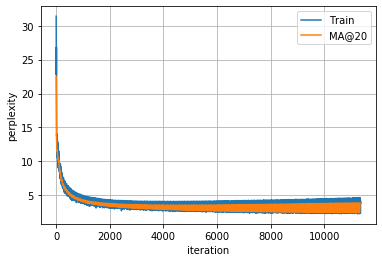

13it [00:01,  9.58it/s]

---- I love the brothing life in jokes.


23it [00:02, 11.49it/s]

---- Admility of a hationalys.


33it [00:02, 11.85it/s]

---- Being had enemy of really as fewing.


40it [00:03, 11.52it/s]


---- I was an on to.very no light.


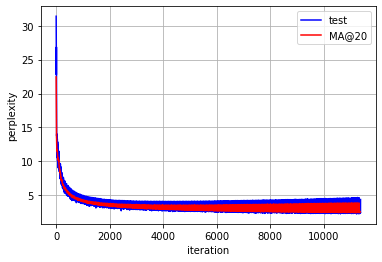

---- Love is always just waite the tolle.


In [177]:
import progressbar
import tqdm
def train_generator(oracle_LSTM, criterion, optimizer, train_loader, test_loader):
    for epoch in range(200):

        bar = progressbar.ProgressBar()
        oracle_LSTM.train()
        for i, (go, eos, mask, length) in tqdm.tqdm(enumerate(train_loader)):
            optimizer.zero_grad()
            prediction = oracle_LSTM(go, length).transpose(2, 1)
            loss = (criterion(prediction, eos) * mask.float()).mean()
            loss.backward()
            [x.grad.clamp_(-1, 1) for x in oracle_LSTM.parameters()]
            optimizer.step()
            losses.append(np.exp(loss.item()))
            if i % 10 == 0:
                print("----", oracle_LSTM.generate(vocab, max_len=100))
            if i % 50 == 0:
                clear_output(True)
                plt.plot(losses, label='Train')
                plt.plot(moving_average(losses), label='MA@20')
                plt.xlabel('iteration')
                plt.ylabel('perplexity')
                plt.legend()
                plt.grid()
                plt.show()
        oracle_LSTM.eval()
        for i, (go, eos, mask, length) in enumerate(test_loader):
            optimizer.zero_grad()
            prediction = oracle_LSTM(go, length).transpose(2, 1)
            loss = (criterion(prediction, eos) * mask.float()).mean()
            losses.append(np.exp(loss.item()))
            if i % 10 == 0:
                print("----", oracle_LSTM.generate(vocab, max_len=100))
            if i % 20 == 0:
                plt.plot(losses, "b", label='test')
                plt.plot(moving_average(losses), "r", label='MA@20')
                plt.xlabel('iteration')
                plt.ylabel('perplexity')
                plt.legend()
                plt.grid()
                plt.show()
train_generator(oracle, criterion, optimizer, train_loader, test_loader)

In [1]:
for _ in range(100)
sentence = oracle.generate(vocab, max_len=100, temperature=0.7)
print(sentence)

NameError: name 'oracle' is not defined

в) Обучить сеть с LSTM вместо GRU

г) Сделать разбиение train-test и нарисровать графики зависимости перплексии от числа эпох

д) Подобрать гиперпараметры, добиться лучшей перплексии чем с параметрами по умолчанию

### LSTM training

In [179]:
class Oracle_LSTM(nn.Module):
    def __init__(self, vocabulary_size, embedding_size=128, hidden_size=256, layers=2):
        super(Oracle_LSTM, self).__init__()
        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocabulary_size, embedding_size)
        self.generator = nn.LSTM(embedding_size, hidden_size, layers, batch_first=False)
        self.classifier = nn.Linear(hidden_size, vocabulary_size)
        self.softmax = nn.Softmax(dim=2)
    # 1) Генерируем эмбединги входных токенов (из _input), пакуем в pack_padded_sequence, используя lengths
    # 2) Запускаем generator на эмбедингах, пакуем его вывод в pad_packed_sequence
    # 3) Возвращаем предикты (пока без SoftMax) через self.classifier
    def forward(self, _input, lengths):
        embedding = self.embedding(_input)
        packed = pack_padded_sequence(embedding, lengths, batch_first=True)
        output, hidden = self.generator(packed)
        output, lengths = pad_packed_sequence(output, batch_first=True)
        logits = self.classifier(output)
        return logits

    # Генерирует последовательность (когда уже обучен). Токены переводим в id с помощью vocab.char_to_id,
    # обратно - с помощью vocab.id_to_char
    # Первый токен - <go>, делаем embeding. Далее generator -- classifier -- softmax.
    # Слово сэмплируем с помощью torch.distributions.Categorical, оно становится новым токеном
    # Повторяем, пока не будет <eos> или не достигнем max_len
    # Возвращаем - сгенерированную строку


    def generate(self, vocab, max_len=100, char="<go>", temperature=1):
        with torch.no_grad():
            
            hidden = (torch.zeros(self.layers, 1, self.hidden_size),
                      torch.zeros(self.layers, 1, self.hidden_size))
         
            generated_text = ""

            for _ in range(max_len):

                input_token = vocab.char_to_id[char]
                input_token = torch.tensor([[input_token]])
                
                embedding = self.embedding(input_token)
                output, hidden = self.generator(embedding, hidden)
                logits = self.classifier(output)

                prediction = self.softmax(logits/temperature)
                char_idx = torch.distributions.Categorical(prediction).sample().item()
                char = vocab.id_to_char[char_idx]

                if char == "<eos>":
                    break

                generated_text += char
            return generated_text

In [180]:
oracle_LSTM = Oracle_LSTM(vocab.size, embedding_size=32, hidden_size=64, layers=2)

In [181]:
criterion_LSTM = nn.CrossEntropyLoss(reduction='none')
learning_rate = 0.01
optimizer_LSTM = torch.optim.Adam(oracle_LSTM.parameters(), lr=learning_rate)
losses = []

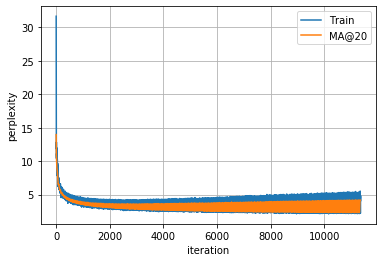

12it [00:01,  8.81it/s]

---- One was infered, like Enging of give accure.


22it [00:02,  8.36it/s]

---- I intent the consest never one started teller.


32it [00:03,  8.83it/s]

---- I think every match so secondering sick life.


40it [00:04,  8.80it/s]


---- Judges free prostory fories.


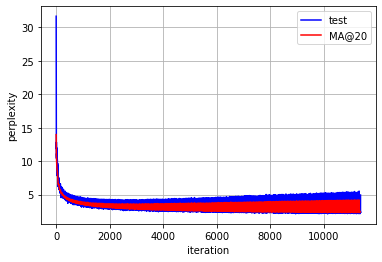

---- There is no inten most vitued. I've most toceresting.


In [182]:
train_generator(oracle_LSTM, criterion_LSTM, optimizer_LSTM, train_loader, test_loader)

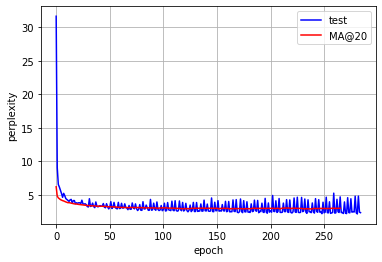

In [187]:
over_epoch_loss = losses[::40]
plt.plot(over_epoch_loss, "b", label='test')
plt.plot(moving_average(over_epoch_loss), "r", label='MA@20')
plt.xlabel('epoch')
plt.ylabel('perplexity')
plt.legend()
plt.grid()
plt.show()

In [188]:
over_epoch_loss[-10:]

[4.418124434918924,
 2.4087643847028164,
 2.502556926243546,
 2.4271375759116176,
 4.802861854047877,
 2.31975048869879,
 2.1550534591973167,
 4.809537219233564,
 2.4210522068656535,
 2.3415862586261205]

### LSTM large training

In [193]:
oracle_LSTM_large = Oracle_LSTM(vocab.size, embedding_size=64, hidden_size=128, layers=2)

In [204]:
criterion_LSTM_large = nn.CrossEntropyLoss(reduction='none')
learning_rate = 0.001
optimizer_LSTM_large = torch.optim.Adam(oracle_LSTM_large.parameters(), lr=learning_rate)
losses = []

In [195]:
def train_generator_n_epochs(oracle_LSTM, criterion, optimizer, train_loader, test_loader, epochs=20):
    for epoch in range(epochs):

        bar = progressbar.ProgressBar()
        oracle_LSTM.train()
        for i, (go, eos, mask, length) in tqdm.tqdm(enumerate(train_loader)):
            optimizer.zero_grad()
            prediction = oracle_LSTM(go, length).transpose(2, 1)
            loss = (criterion(prediction, eos) * mask.float()).mean()
            loss.backward()
            [x.grad.clamp_(-1, 1) for x in oracle_LSTM.parameters()]
            optimizer.step()
            losses.append(np.exp(loss.item()))
            if i % 10 == 0:
                print("----", oracle_LSTM.generate(vocab, max_len=100))
            if i % 50 == 0:
                clear_output(True)
                plt.plot(losses, label='Train')
                plt.plot(moving_average(losses), label='MA@20')
                plt.xlabel('iteration')
                plt.ylabel('perplexity')
                plt.legend()
                plt.grid()
                plt.show()
        oracle_LSTM.eval()
        for i, (go, eos, mask, length) in enumerate(test_loader):
            optimizer.zero_grad()
            prediction = oracle_LSTM(go, length).transpose(2, 1)
            loss = (criterion(prediction, eos) * mask.float()).mean()
            losses.append(np.exp(loss.item()))
            if i % 10 == 0:
                print("----", oracle_LSTM.generate(vocab, max_len=100))
            if i % 20 == 0:
                plt.plot(losses, "b", label='test')
                plt.plot(moving_average(losses), "r", label='MA@20')
                plt.xlabel('iteration')
                plt.ylabel('perplexity')
                plt.legend()
                plt.grid()
                plt.show()

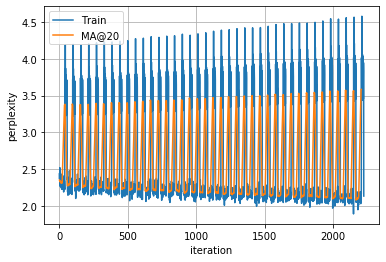

11it [00:02,  4.35it/s]

---- We mokel huroul the clothes around by it.


21it [00:04,  4.45it/s]

---- I'm rubbish and kifs talk to be undestence.


32it [00:07,  4.88it/s]

---- You can't pay to weave make curable.


40it [00:08,  4.60it/s]


---- The funny bass of the impections.


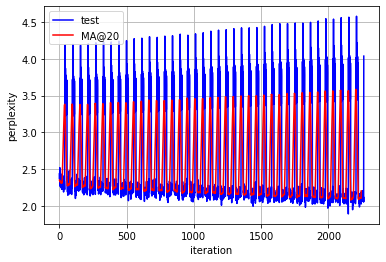

---- Negett is like to make a tree.


In [205]:
train_generator_n_epochs(oracle_LSTM_large, criterion_LSTM_large, optimizer_LSTM_large, train_loader, test_loader, epochs=40)

In [210]:
sentence = oracle_LSTM_large.generate(vocab, max_len=100, temperature=0.7)
print(sentence)

God is sets everything can get life.


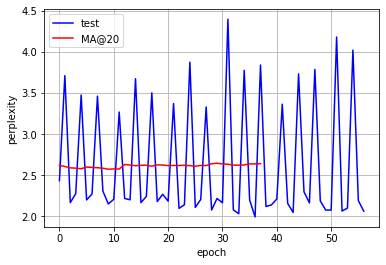

In [207]:
over_epoch_loss = losses[::40]
plt.plot(over_epoch_loss, "b", label='test')
plt.plot(moving_average(over_epoch_loss), "r", label='MA@20')
plt.xlabel('epoch')
plt.ylabel('perplexity')
plt.legend()
plt.grid()
plt.show()

In [208]:
over_epoch_loss[-10:]

[3.7883547784524247,
 2.1882446898040295,
 2.0761524022782054,
 2.077272998187505,
 4.182144530616778,
 2.0647904686127667,
 2.1013121774168355,
 4.022538518431574,
 2.1920935249847644,
 2.0629037896062608]

#### Как можно увидеть, я использовал не совсем те параметры, которые были предложены авторами ноутбука. Обучать модель 1000 эпох не было времени. Но, я обучил ее на 200 эпохах и обучил такую же LSTM. LSTM оказалась немного лучше, хотя и не сильно заметно

**Спасибо за выполнение заданий!**